### Run Model Training (Multiple Configurations)

Run `Model.py` for different CPU worker counts (1, 2, 4) and once for GPU.
Metrics and weights will be saved separately for each configuration.

In [7]:
import os
import json

# --- Configuration ---
epochs = 5
batch_size = 32
cpu_workers_list = [1, 2, 4] # CPU workers to test
gpu_workers = 2 # Workers to use for GPU run (adjust if needed)
base_output_dir = "training_results" # Directory to store results

os.makedirs(base_output_dir, exist_ok=True)

all_metrics = {}
run_configs = {}

# --- Run CPU Configurations ---
for n_workers in cpu_workers_list:
    config_name = f"cpu_{n_workers}_workers"
    metrics_file = os.path.join(base_output_dir, f"{config_name}_metrics.json")
    weights_file = os.path.join(base_output_dir, f"{config_name}_model.pth")
    run_configs[config_name] = {'device': 'cpu', 'workers': n_workers}

    print(f"--- Running Training: {config_name} ---")
    command = (
        f"python Model.py --device cpu --epochs {epochs} --batch_size {batch_size} "
        f"--num_workers {n_workers} --output_file {metrics_file} --save_weights {weights_file}"
    )
    print(f"Executing: {command}")
    get_ipython().system(command)

    # Load metrics immediately after run
    if os.path.exists(metrics_file):
        with open(metrics_file, 'r') as f:
            all_metrics[config_name] = json.load(f)
        print(f"Loaded metrics for {config_name}")
    else:
        print(f"Metrics file not found after run: {metrics_file}")
        all_metrics[config_name] = None # Placeholder if run failed

# --- Run GPU Configuration ---
config_name_gpu = f"gpu_{gpu_workers}_workers"
metrics_file_gpu = os.path.join(base_output_dir, f"{config_name_gpu}_metrics.json")
weights_file_gpu = os.path.join(base_output_dir, f"{config_name_gpu}_model.pth")
run_configs[config_name_gpu] = {'device': 'cuda', 'workers': gpu_workers}


print(f"--- Running Training: {config_name_gpu} ---")
command_gpu = (
    f"python Model.py --device cuda --epochs {epochs} --batch_size {batch_size} "
    f"--num_workers {gpu_workers} --output_file {metrics_file_gpu} --save_weights {weights_file_gpu}"
)
print(f"Executing: {command_gpu}")
get_ipython().system(command_gpu)

# Load GPU metrics
if os.path.exists(metrics_file_gpu):
    with open(metrics_file_gpu, 'r') as f:
        all_metrics[config_name_gpu] = json.load(f)
    print(f"Loaded metrics for {config_name_gpu}")
else:
    print(f"Metrics file not found after run: {metrics_file_gpu}")
    all_metrics[config_name_gpu] = None # Placeholder if run failed

print("\\n--- All Training Runs Complete ---")
print("Loaded metrics keys:", list(all_metrics.keys()))

# Display loaded times for verification
for name, metrics in all_metrics.items():
    if metrics:
        time_taken = metrics.get('time', 'N/A')
        print(f"{name}: Training Time = {time_taken:.2f}s" if isinstance(time_taken, (int, float)) else f"{name}: Training Time = {time_taken}")
    else:
        print(f"{name}: Metrics not loaded.")


--- Running Training: cpu_1_workers ---
Executing: python Model.py --device cpu --epochs 5 --batch_size 32 --num_workers 1 --output_file training_results/cpu_1_workers_metrics.json --save_weights training_results/cpu_1_workers_model.pth
Starting training run with config: Namespace(device='cpu', epochs=5, batch_size=32, num_workers=1, train_dir='RevisedData/train', val_dir='RevisedData/validation', load_weights=None, save_weights='training_results/cpu_1_workers_model.pth', output_file='training_results/cpu_1_workers_metrics.json')
Using device: cpu
Loading datasets...
Found 6300 training images and 700 validation images.
Preparing dataloaders...
Initializing model...
Number of classes detected: 4
Starting with pre-trained ResNet weights (no specific file loaded).
Starting training...
Epoch 1/5
----------
Train Epoch 1/5: 100%|█| 197/197 [03:12<00:00,  1.02it/s, acc=0.679, loss=0.927]
Train Loss: 0.9658 Acc: 0.5989
Val Epoch 1/5: 100%|█████| 22/22 [00:20<00:00,  1.10it/s, acc=0.679, loss

### Performance Comparison: CPU Workers vs. GPU

Visualize the differences in training time and accuracy across all configurations.

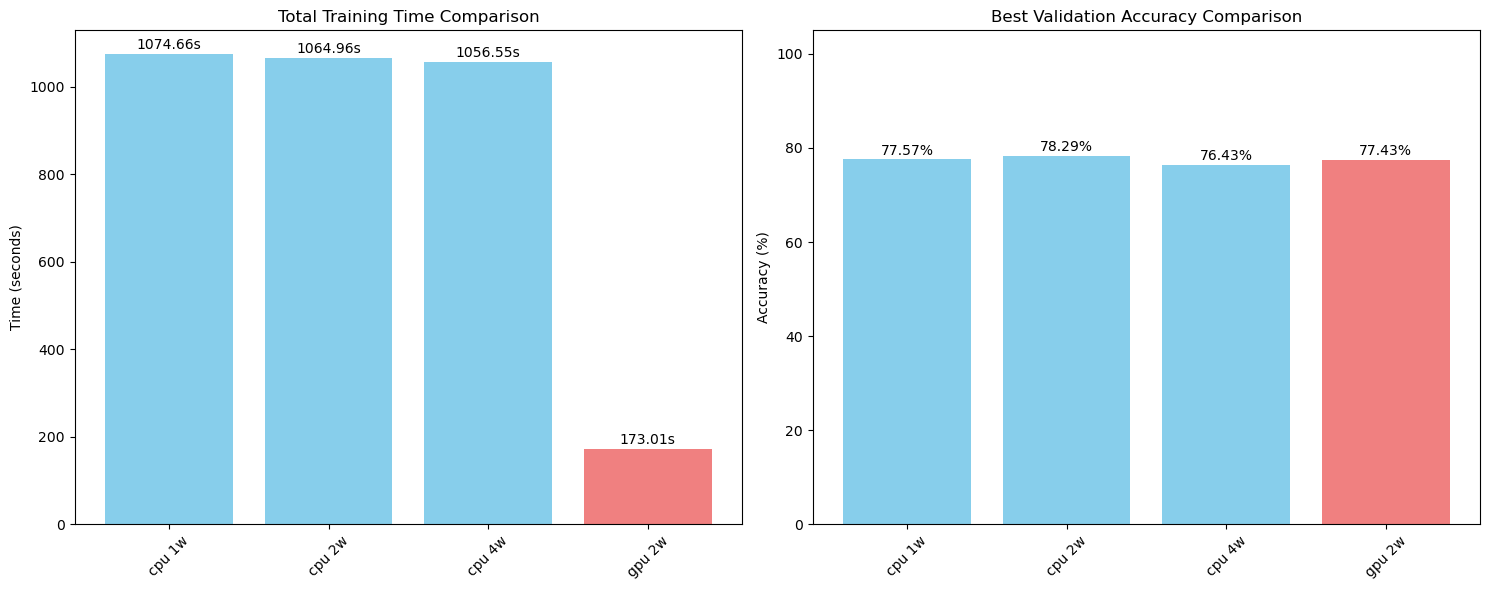

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
labels = []
times = []
best_val_accs = []

# Ensure consistent ordering for plots (CPU 1, 2, 4, then GPU)
config_order = [f"cpu_{n}_workers" for n in cpu_workers_list] + [config_name_gpu]

for name in config_order:
    metrics = all_metrics.get(name)
    if metrics:
        labels.append(name.replace("_", " ").replace(" workers", "w")) # Shorter labels
        times.append(metrics.get('time', 0))
        best_val_accs.append(metrics.get('best_val_acc', 0) * 100) # Percentage
    else:
        print(f"Warning: No metrics found for {name}, skipping in plot.")

if not labels:
    print("No valid metrics loaded, cannot generate comparison plots.")
else:
    fig, axs = plt.subplots(1, 2, figsize=(15, 6)) # Adjusted figure size

    # Plot Training Time
    axs[0].bar(labels, times, color=['skyblue']*len(cpu_workers_list) + ['lightcoral'])
    axs[0].set_ylabel('Time (seconds)')
    axs[0].set_title('Total Training Time Comparison')
    axs[0].tick_params(axis='x', rotation=45) # Rotate labels if needed
    for i, t in enumerate(times):
        axs[0].text(i, t + max(times)*0.01, f"{t:.2f}s", ha='center')

    # Plot Best Validation Accuracy
    axs[1].bar(labels, best_val_accs, color=['skyblue']*len(cpu_workers_list) + ['lightcoral'])
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].set_ylim(0, 105) # Set y-limit for percentage
    axs[1].set_title('Best Validation Accuracy Comparison')
    axs[1].tick_params(axis='x', rotation=45) # Rotate labels if needed
    for i, acc in enumerate(best_val_accs):
        axs[1].text(i, acc + 1, f"{acc:.2f}%", ha='center')

    plt.tight_layout()
    plt.show()

### Accuracy and Loss Curves: CPU Workers vs. GPU

Plot the training and validation accuracy and loss curves over epochs for all configurations.

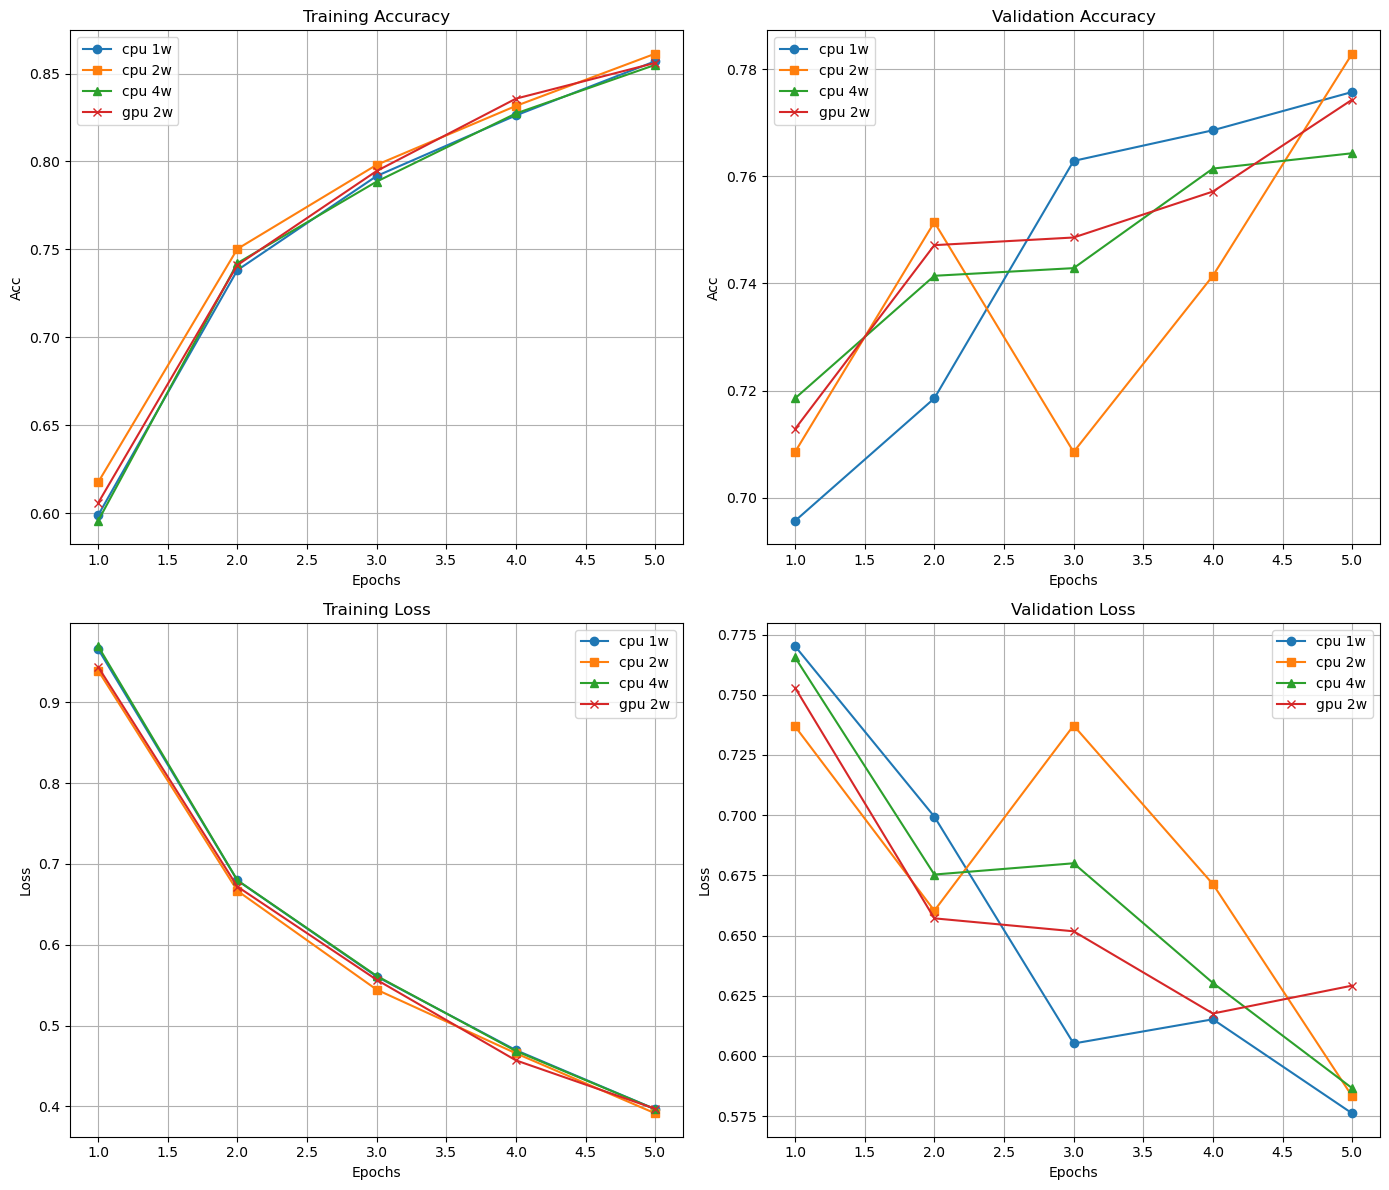

In [9]:
# Plotting training and validation curves for all configs
if any(all_metrics.values()): # Check if at least one metric set was loaded
    plt.figure(figsize=(14, 12)) # Adjusted figure size
    epochs = []
    # Try to get epochs from the first valid metric set
    for name in config_order:
        metrics = all_metrics.get(name)
        if metrics and 'epochs' in metrics and metrics['epochs']:
            epochs = metrics['epochs']
            break
        elif metrics and 'train_loss' in metrics and metrics['train_loss']: # Fallback
             epochs = list(range(1, len(metrics['train_loss']) + 1))
             break

    if not epochs:
        print("Could not determine epochs from metrics. Cannot plot curves.")
    else:
        plot_configs = [
            ('train_acc', 'Training Accuracy'),
            ('val_acc', 'Validation Accuracy'),
            ('train_loss', 'Training Loss'),
            ('val_loss', 'Validation Loss')
        ]
        markers = ['o', 's', '^', 'x', 'd', '+'] # Different markers for lines

        for i, (metric_key, plot_title) in enumerate(plot_configs):
            plt.subplot(2, 2, i + 1)
            marker_idx = 0
            for name in config_order:
                metrics = all_metrics.get(name)
                if metrics and metric_key in metrics and len(metrics[metric_key]) == len(epochs):
                    label_short = name.replace("_", " ").replace(" workers", "w")
                    plt.plot(epochs, metrics[metric_key], label=label_short, marker=markers[marker_idx % len(markers)])
                    marker_idx += 1
                elif metrics:
                     print(f"Warning: Metric '{metric_key}' missing or length mismatch for {name}. Skipping in plot '{plot_title}'.")


            plt.title(plot_title)
            plt.xlabel('Epochs')
            plt.ylabel(metric_key.split('_')[1].capitalize()) # 'Accuracy' or 'Loss'
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()
else:
    print("No metrics loaded for any configuration. Cannot plot curves.")


/tmp/ipykernel_3504379/2771258368.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


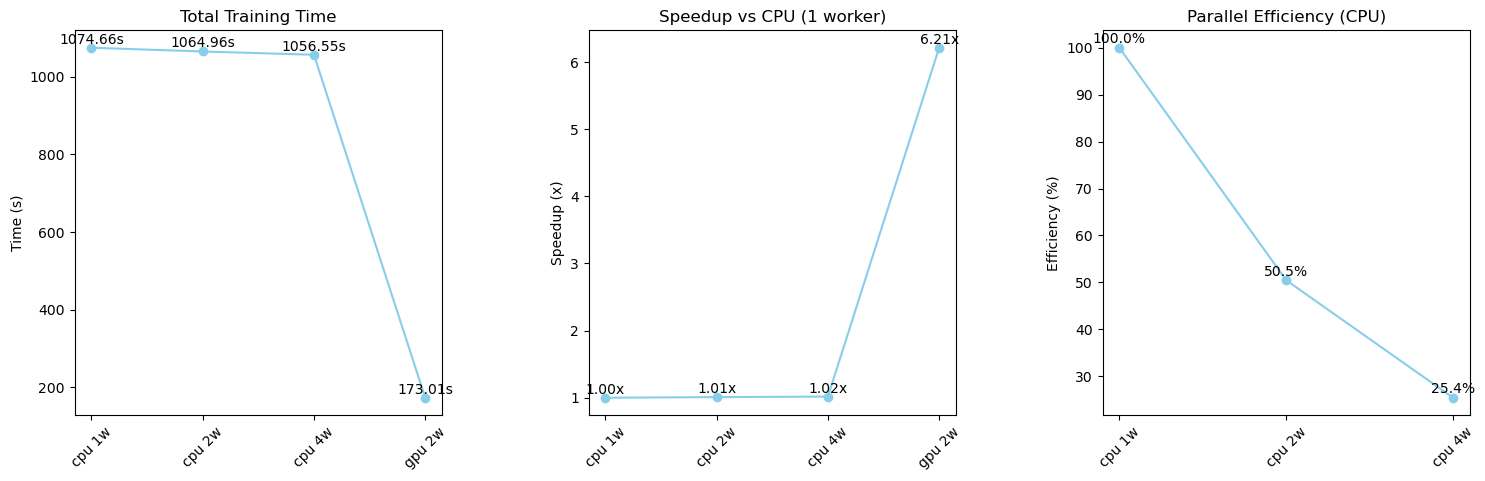

In [10]:
import matplotlib.pyplot as plt

# Define configuration order and labels
config_order = [f"cpu_{n}_workers" for n in cpu_workers_list] + [config_name_gpu]
labels = [name.replace('_', ' ').replace(' workers', 'w') for name in config_order]

# Extract times
times = [all_metrics[name].get('time', 0) for name in config_order]
baseline = times[0] if times and times[0] > 0 else None

# Compute speedup
speedup = [ (baseline / t) if baseline and t>0 else 0 for t in times ]

# Compute efficiency for CPU only
efficiency = []
for name, sp in zip(config_order, speedup):
    if name.startswith('cpu_'):
        workers = int(name.split('_')[1])
        efficiency.append((sp / workers) * 100 if workers>0 else 0)
    else:
        efficiency.append(None)

# Plotting in a fitted layout
grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)
fig = plt.figure(figsize=(18, 5))

# Total Time Line Plot
ax1 = fig.add_subplot(grid[0, 0])
ax1.plot(labels, times, marker='o', linestyle='-', color='skyblue')
ax1.set_title('Total Training Time')
ax1.set_ylabel('Time (s)')
ax1.tick_params(axis='x', rotation=45)
for i, t in enumerate(times):
    ax1.text(i, t + max(times)*0.01, f"{t:.2f}s", ha='center')

# Speedup Line Plot
ax2 = fig.add_subplot(grid[0, 1])
ax2.plot(labels, speedup, marker='o', linestyle='-', color='skyblue')
ax2.set_title('Speedup vs CPU (1 worker)')
ax2.set_ylabel('Speedup (x)')
ax2.tick_params(axis='x', rotation=45)
for i, s in enumerate(speedup):
    ax2.text(i, s + max(speedup)*0.01, f"{s:.2f}x", ha='center')

# Efficiency Line Plot (CPU only)
eff_labels = labels[:len(cpu_workers_list)]
eff_vals = efficiency[:len(cpu_workers_list)]
ax3 = fig.add_subplot(grid[0, 2])
ax3.plot(eff_labels, eff_vals, marker='o', linestyle='-', color='skyblue')
ax3.set_title('Parallel Efficiency (CPU)')
ax3.set_ylabel('Efficiency (%)')
ax3.tick_params(axis='x', rotation=45)
for i, e in enumerate(eff_vals):
    ax3.text(i, e + max(eff_vals)*0.01, f"{e:.1f}%", ha='center')

plt.tight_layout()
plt.show()